In [1]:
from apyori import apriori

In [21]:
transactions = [
    ['beer', 'diapers'],
    ['diapers', 'milk'],
    ['beer', 'nuts', 'diapers'],    
    ['milk', 'nuts']
]

In [30]:
rec = apriori(transactions, min_confidence=0.8, min_support=0.5)
l = list(rec)

In [31]:
print(l)

[RelationRecord(items=frozenset({'diapers', 'beer'}), support=0.5, ordered_statistics=[OrderedStatistic(items_base=frozenset({'beer'}), items_add=frozenset({'diapers'}), confidence=1.0, lift=1.3333333333333333)])]


In [32]:
def pprint_records(rec_list):
    r = rec_list.copy()
    for row in r:
        print(f'Items:  {set(row.items)}')
        print(f'Support: {row.support:.4f}')
        print('BODY -> HEAD[Confidence, Lift]\n')
        for os in row.ordered_statistics:
            print(f'\t{set(os.items_base)}  ->  {set(os.items_add)}[{os.confidence:.2f}, {os.lift:.2f}]\n\n')

In [33]:
pprint_records(l)

Items:  {'diapers', 'beer'}
Support: 0.5000
BODY -> HEAD[Confidence, Lift]

	{'beer'}  ->  {'diapers'}[1.00, 1.33]




## Our own data

In [35]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [39]:
all_raw = pd.read_csv('cleansed_data//all_consumption_metadata.csv', parse_dates=True, index_col=0,
                     dtype={'loc_id':'str', 'consumption_kvah':'float32', 'temperature':'float32',
                           'el_price':'float32', 'oil_price':'float32'})
all_raw.head()

,loc_id,consumption_kvah,temperature,el_price,oil_price
time,,,,,
2018-01-01 00:00:00,0,27.0,5.5,26.330000,66.730003
2018-01-01 01:00:00,0,27.5,5.0,26.430000,66.730003
2018-01-01 02:00:00,0,27.0,4.8,26.100000,66.730003
2018-01-01 03:00:00,0,23.0,4.9,24.700001,66.730003
2018-01-01 04:00:00,0,23.0,3.7,24.740000,66.730003


In [40]:
all_df = all_raw.copy()

Separate all locations

In [42]:
loc_ids = all_df['loc_id'].unique()

d = {}

for loc in loc_ids: 
    d[loc] = all_df[all_df['loc_id']==loc]
    print(f'Length of {loc}: {len(d[loc])}')

Length of 0: 18385
Length of 1: 18385
Length of 3: 18385
Length of 4: 18385
Length of 6: 18385
Length of 10: 18385
Length of 11: 18385
Length of 12: 18385
Length of 16: 18385
Length of 17: 18385
Length of 18: 18385
Length of 19: 18385
Length of 7: 18344
Length of 8: 16111
Length of 14: 15299
Length of 2: 15134
Length of 5: 14001
Length of 15: 12493
Length of 13: 6090
Length of 9: 11783


13 is probably a nice sample dataset

In [53]:
sample = d['13']

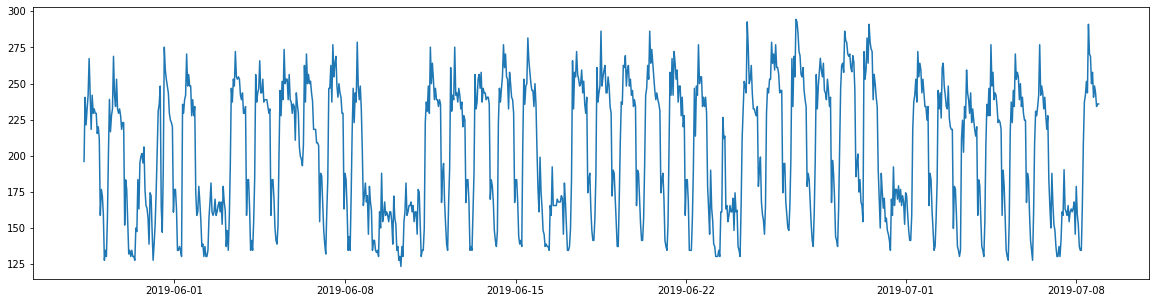

In [54]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
ax.plot(sample['consumption_kvah'][:1000])
plt.show()

Might be, might not be. Considering the distinct even peaks this timeseries is probably not representative of private householdings, but rather some commercial customer.

It should do for prototyping anyway.

### **Test 1**: Bucket all numerical values in percentiles

In [237]:
loc = '13'
sample = d[loc]
sample = sample.drop(['loc_id'], axis=1)

In [326]:
def create_percentile_mask_dict(df, means=None, stds=None):
    
    df_copy = df.copy()
    cols = df_copy.columns
    
    if means==None: means = [np.mean(sample[c]) for c in cols]
    if stds==None: stds = [np.std(sample[c]) for c in cols]
        
    masks = {}
    masks['m3std'] = [df_copy[c]<(m-3*s) for c, m, s in zip(cols, means, stds)]
    masks['m2std'] = [(df_copy[c]<(m-2*s)) & ~m3std for c, m, s, m3std in zip(cols, means, stds, masks['m3std'])]
    masks['m1std'] = [(df_copy[c]<(m-s)) & ~(m3std|m2std) for c, m, s, m3std, m2std in zip(cols, means, stds, masks['m3std'], masks['m2std'])]

    masks['m0std'] = [(df_copy[c]< =(m+s)) & ~(m3std|m2std|m1std) for c, m, s, m3std, m2std, m1std 
                 in zip(cols, means, stds, masks['m3std'], masks['m2std'], masks['m1std'])]

    masks['p3std'] = [df_copy[c]>(m+3*s) for c, m, s in zip(cols, means, stds)]
    masks['p2std'] = [(df_copy[c]>(m+2*s)) & ~p3std for c, m, s, p3std in zip(cols, means, stds, masks['p3std'])]
    masks['p1std'] = [(df_copy[c]>(m+s)) & ~(p3std|p2std) for c, m, s, p3std, p2std in zip(cols, means, stds, masks['p3std'], masks['p2std'])]
    
    return masks.copy()

In [327]:
def create_transactions_array(d, n):
    transactions = []
    
    i = 0
    while i < n:
        row = []
        for name, m in d.items():
            for entry in m:
                if entry[i]: row.append(name+'_'+entry.name)
        transactions.append(row)
        i += 1
        
    return transactions

In [328]:
masks = create_percentile_dict(sample)

for _, v in masks.items():
    n = len(v[0])
    break
    
transactions = create_transactions_array(masks, n)

In [329]:
n

6090

sample is only 6000 rows, so looking for rules with 1% support means at least 60 rows confirm this. Going much lower than this might very well destroy the validity of the rule.

In [330]:
rec = apriori(transactions, min_support=0.01, min_confidence=0.6, min_lift=10)
pprint_records(list(rec))

Items:  {'m2std_el_price', 'm2std_oil_price'}
Support: 0.0112
BODY -> HEAD[Confidence, Lift]

	{'m2std_oil_price'}  ->  {'m2std_el_price'}[0.70, 18.24]




This is our most solid rule with support threshold at 1%. When oil price $\in (0.2,2.1)$  percentile, so is probably the el price.

In [331]:
rec = apriori(transactions, min_support=0.01, min_confidence=0.6, min_lift=1.75)
pprint_records(list(rec))

Items:  {'m2std_el_price', 'm2std_oil_price'}
Support: 0.0112
BODY -> HEAD[Confidence, Lift]

	{'m2std_oil_price'}  ->  {'m2std_el_price'}[0.70, 18.24]


Items:  {'p2std_temperature', 'p1std_consumption_kvah'}
Support: 0.0110
BODY -> HEAD[Confidence, Lift]

	{'p2std_temperature'}  ->  {'p1std_consumption_kvah'}[0.66, 4.03]


Items:  {'m1std_oil_price', 'm0std_el_price', 'p1std_consumption_kvah', 'p1std_temperature'}
Support: 0.0169
BODY -> HEAD[Confidence, Lift]

	{'m1std_oil_price', 'm0std_el_price', 'p1std_consumption_kvah'}  ->  {'p1std_temperature'}[0.69, 4.06]




**Surprising remark**: When temperature $\in (97.7, 99.8)$ percentile, the consumption is typically moderately high.

This could say something about this particular customer, and it's likely that this rule won't hold water for the other locations in general.

### Run percentile mining on `Oilspot_prices` and `Elspot_prices`

Since we only have daily values on oilspot prices, and hourly on elspot, it's probably fair to resample the elspot prices.

In [705]:
oilspot = pd.read_csv('cleansed_data//Oilspot_prices.csv', index_col=0, parse_dates=True, dtype='float32')
oilspot['day'] = oilspot.index.date
oilspot.head(3)

,price,day
2017-04-06,53.619999,2017-04-06
2017-04-07,54.240002,2017-04-07
2017-04-08,54.240002,2017-04-08


In [706]:
elspot = pd.read_csv('cleansed_data//Elspot_prices.csv', index_col=0, parse_dates=True, dtype='float32')
elspot = elspot.resample(rule='D').mean()
elspot['day'] = elspot.index.date
elspot.head(3)

,price,day
2018-01-01,26.039583,2018-01-01
2018-01-02,31.792084,2018-01-02
2018-01-03,28.320417,2018-01-03


In [707]:
oil_el = oilspot.merge(elspot, how='inner', left_on='day', right_on='day', suffixes=('_oil', '_el'))

In [708]:
oil_el_days = oil_el['day']
oil_el = oil_el.drop('day', axis=1)
oil_el.head(3)

,price_oil,price_el
0,66.730003,26.039583
1,66.650002,31.792084
2,67.849998,28.320417


In [709]:
means = [np.mean(df['price']) for df in [oilspot, elspot]]
stds = [np.std(df['price']) for df in [oilspot, elspot]]

In [710]:
perc_masks = create_percentile_mask_dict(oil_el, means=means, stds=stds)

In [711]:
def create_date_mask_dict(date_ts, weekday=False, month=False):
    
    df = date_ts.copy().to_frame()
    
    date_col = df.columns[0]
    
    masks = {}
    
    if weekday:
        df['weekday'] = [d.weekday() for d in df[date_col]]
        
        weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

        for i, day in enumerate(weekdays):
            masks[day] = [df['weekday']==i]
            
    if month:
        df['month'] = [d.month for d in df[date_col]]
        
        months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
                  'August', 'September', 'October', 'November', 'December']
        
        for i, m in enumerate(months):
            masks[m] = [df['month']==i]
        
    return masks.copy()

In [719]:
date_masks = create_date_mask_dict(oil_el_days, weekday=True, month=False)

In [721]:
all_masks = date_masks.copy()
all_masks.update(perc_masks)

In [722]:
n = len(date_masks['Monday'][0])
n

827

In [723]:
transactions = create_transactions_array(all_masks, n)

In [733]:
min_support = 10/n
rec = apriori(transactions, min_support=min_support, min_confidence=0.6, min_lift=1.2)
pprint_records(list(rec))

Items:  {'m2std_price_el', 'm3std_price_oil'}
Support: 0.0266
BODY -> HEAD[Confidence, Lift]

	{'m3std_price_oil'}  ->  {'m2std_price_el'}[1.00, 14.51]




Cool! Extremely low oil prices has a definite impact on el prices! 

This is the strongest rule by far for this support. No other rule is even above lift 1.2.

Lift 1.2 is really not impressive, so we're upping the support.

In [756]:
min_support = 25/n
rec = apriori(transactions, min_support=min_support, min_confidence=0.6, min_lift=1.2)
pprint_records(list(rec))

Actually, we're not able to find anything of interest here! At any n, we find no rule with more than 1.2 lift

The rule high temperatures imply slightly higher oil prices seem to hold water.

Also, some indication that slightly lower el prices are accompanied by normal temperature and oil prices.

Extremely low oil prices definitely made the el prices drop!

On the general side, normal oil prices are slightly more prevalent during times of a bit colder temperatures.

The strength of the rule is slightly increased if there also are normal el prices.

### How 'bout weather, oil and el prices?

In [757]:
w = pd.read_csv('cleansed_data//Weather.csv', index_col=[0,1], 
                dtype={'temperature':'float32', 'weather_station':'str'}, parse_dates=True)
w.head(3)

,,temperature
,weather_station,
2018-01-01 00:00:00,SN35210,-0.3
2018-01-01 01:00:00,SN35210,-0.5
2018-01-01 02:00:00,SN35210,-1.4


Let's make one complete temperature series using the median measurement in Agder.

In [694]:
first_date = min(w.index.get_level_values(0))
last_date = max(w.index.get_level_values(0))
median_temps = pd.DataFrame(index=pd.date_range(start=first_date, end=last_date, freq='H'), columns=['temperature'])

In [695]:
median_temps['temperature'] = [np.nanmedian(w.loc[idx]) for idx in median_temps.index]
median_temps = median_temps.resample(rule='D').mean()

In [758]:
median_temps.head()

,temperature,day
2018-01-01,4.054167,2018-01-01
2018-01-02,1.866667,2018-01-02
2018-01-03,2.341667,2018-01-03
2018-01-04,1.425000,2018-01-04
2018-01-05,0.541667,2018-01-05


In [697]:
median_temps['day'] = median_temps.index.date

In [698]:
temp_el = median_temps.merge(elspot.drop('day', axis=1), how='inner', left_index=True, right_index=True)

In [699]:
temp_el_oil = temp_el.merge(oilspot, how='inner', left_on='day', right_on='day', suffixes=('_el', '_oil'))

temp_el_oil_days = temp_el_oil['day']
temp_el_oil = temp_el_oil.drop('day', axis=1)

In [759]:
temp_el_oil.head()

,temperature,price_el,price_oil
0,4.054167,26.039583,66.730003
1,1.866667,31.792084,66.650002
2,2.341667,28.320417,67.849998
3,1.425000,31.970833,68.730003
4,0.541667,31.174999,68.010002


In [760]:
means = [np.mean(median_temps['temperature']), np.mean(elspot['price']), np.mean(oilspot['price'])]
stds = [np.std(median_temps['temperature']), np.std(elspot['price']), np.std(oilspot['price'])]

temp_el_oil.head()

,temperature,price_el,price_oil
0,4.054167,26.039583,66.730003
1,1.866667,31.792084,66.650002
2,2.341667,28.320417,67.849998
3,1.425000,31.970833,68.730003
4,0.541667,31.174999,68.010002


In [761]:
perc_masks = create_percentile_mask_dict(temp_el_oil, means=means, stds=stds)
date_masks = create_date_mask_dict(temp_el_oil_days, weekday=True, month=False)

all_masks = date_masks.copy()
all_masks.update(perc_masks)

n = len(perc_masks['m0std'][0])
transactions = create_transactions_array(all_masks, n)

In [762]:
n

790

Any specific rules for low support?

In [779]:
min_support = 5/n
rec = apriori(transactions, min_support=min_support, min_confidence=0.6, min_lift=5)
pprint_records(list(rec))

Items:  {'p1std_price_el', 'm1std_price_oil'}
Support: 0.0127
BODY -> HEAD[Confidence, Lift]

	{'m1std_price_oil'}  ->  {'p1std_price_el'}[0.71, 5.22]


Items:  {'m1std_temperature', 'p2std_price_el'}
Support: 0.0089
BODY -> HEAD[Confidence, Lift]

	{'p2std_price_el'}  ->  {'m1std_temperature'}[1.00, 5.85]


Items:  {'m1std_temperature', 'm0std_price_oil', 'p2std_price_el'}
Support: 0.0089
BODY -> HEAD[Confidence, Lift]

	{'p2std_price_el'}  ->  {'m1std_temperature', 'm0std_price_oil'}[1.00, 6.12]


	{'m0std_price_oil', 'p2std_price_el'}  ->  {'m1std_temperature'}[1.00, 5.85]


Items:  {'p1std_price_el', 'm0std_temperature', 'm1std_price_oil'}
Support: 0.0089
BODY -> HEAD[Confidence, Lift]

	{'m0std_temperature', 'm1std_price_oil'}  ->  {'p1std_price_el'}[0.70, 5.12]




Seems that in times of very high el prices, you may expect there to be moderately cold weather.

Arguably moderately low oil prices may lead to moderately high el prices.

Any general rules?

In [785]:
min_support = 25/n
rec = apriori(transactions, min_support=min_support, min_confidence=0.6, min_lift=1.3)
pprint_records(list(rec))

Items:  {'m0std_temperature', 'm1std_price_el'}
Support: 0.0405
BODY -> HEAD[Confidence, Lift]

	{'m1std_price_el'}  ->  {'m0std_temperature'}[0.84, 1.37]


Items:  {'m1std_price_el', 'm0std_temperature', 'm0std_price_oil'}
Support: 0.0354
BODY -> HEAD[Confidence, Lift]

	{'m1std_price_el'}  ->  {'m0std_temperature', 'm0std_price_oil'}[0.74, 1.53]


	{'m1std_price_el', 'm0std_price_oil'}  ->  {'m0std_temperature'}[0.88, 1.43]




In times of moderately low el prices the probability of normal temperature and oil prices is higher than usual.

Summary thus far:
 * Strong indication that extremely low oil prices drive down el prices substantially.
 * In times of very high el prices, the weather is much more likely to be cold than elsewhen.
 * Good indications that slightly low oil prices drive el prices slightly up.

## Mix in consumption

In [840]:
df_copy.head()

,consumption_kvah,temperature,el_price,oil_price
idx,,,,
0,111.317436,10.386364,45.435455,85.449997
1,107.572670,10.400000,47.715416,86.070000
2,104.631226,12.108334,46.195835,85.120003
3,92.616318,9.412500,46.522499,85.120003
4,94.981438,9.025000,46.345833,85.120003


In [841]:
transactions = []

for loc, df in d.items():
    df_copy = df.copy()
        
    df_copy = df_copy.drop('loc_id', axis=1)
    
    df_copy = df_copy.resample(rule='D').mean()
    
    df_copy['day'] = df_copy.index.date

    df_copy['idx'] = [i for i in range(len(df_copy))]
    df_copy = df_copy.set_index('idx')
    
    df_copy_days = df_copy['day']
    df_copy = df_copy.drop('day', axis=1)
        
    means = [np.mean(df_copy['consumption_kvah']), np.mean(median_temps['temperature']), 
             np.mean(elspot['price']), np.mean(oilspot['price'])]
    
    stds = [np.std(df_copy['consumption_kvah']), np.std(median_temps['temperature']), 
             np.std(elspot['price']), np.std(oilspot['price'])]
    
    perc_masks = create_percentile_mask_dict(df_copy, means=means, stds=stds)
    date_masks = create_date_mask_dict(df_copy_days, weekday=True, month=False)
    
    all_masks = date_masks.copy()
    all_masks.update(perc_masks)

    n = len(perc_masks['m0std'][0])
    trans = [t+[f'loc_{loc}'] for t in create_transactions_array(all_masks, n)]
    
    transactions += trans

In [856]:
min_support = 5/n
rec = apriori(transactions, min_support=min_support, min_confidence=0.8, min_lift=5)
pprint_records(list(rec))

Items:  {'m1std_oil_price', 'p1std_el_price'}
Support: 0.0138
BODY -> HEAD[Confidence, Lift]

	{'m1std_oil_price'}  ->  {'p1std_el_price'}[0.83, 5.89]




This is old news, eyh?

In [855]:
min_support = 5/n
rec = apriori(transactions, min_support=min_support, min_confidence=0.8, min_lift=4.3)
pprint_records(list(rec))

Items:  {'p2std_temperature', 'm1std_consumption_kvah'}
Support: 0.0155
BODY -> HEAD[Confidence, Lift]

	{'p2std_temperature'}  ->  {'m1std_consumption_kvah'}[0.83, 4.37]


Items:  {'m1std_oil_price', 'p1std_el_price'}
Support: 0.0138
BODY -> HEAD[Confidence, Lift]

	{'m1std_oil_price'}  ->  {'p1std_el_price'}[0.83, 5.89]


Items:  {'p1std_temperature', 'loc_8', 'm1std_consumption_kvah'}
Support: 0.0102
BODY -> HEAD[Confidence, Lift]

	{'p1std_temperature', 'loc_8'}  ->  {'m1std_consumption_kvah'}[0.83, 4.41]


Items:  {'p1std_temperature', 'p1std_el_price', 'm0std_oil_price', 'm1std_consumption_kvah'}
Support: 0.0142
BODY -> HEAD[Confidence, Lift]

	{'p1std_el_price', 'm0std_oil_price', 'm1std_consumption_kvah'}  ->  {'p1std_temperature'}[0.84, 4.43]




**Take-home**: 
 * Very high temperatures imply moderately low consumption.
 * Again: Slightly lower oil prices imply slightly higher el prices.
 * At location 8, slightly high temperatures imply slightly higher consumption.
 * You're more likely than elsewhen to observe moderately high temperature when el prices are moderately high, oil prices are normal and consumption is moderately low.

Upping support to fetch more general data

In [872]:
min_support = 10/n
rec = apriori(transactions, min_support=min_support, min_confidence=0.7, min_lift=3)
pprint_records(list(rec))

Items:  {'p1std_temperature', 'p1std_el_price', 'm1std_consumption_kvah'}
Support: 0.0305
BODY -> HEAD[Confidence, Lift]

	{'p1std_temperature', 'p1std_el_price'}  ->  {'m1std_consumption_kvah'}[0.74, 3.94]


Items:  {'m1std_temperature', 'p1std_consumption_kvah', 'm0std_oil_price', 'p1std_el_price'}
Support: 0.0225
BODY -> HEAD[Confidence, Lift]

	{'m1std_temperature', 'p1std_el_price', 'm0std_oil_price'}  ->  {'p1std_consumption_kvah'}[0.71, 4.00]




High temperatures and high el prices imply low consumption,

low temperatures and high el prices imply high consumption

Upping support

In [887]:
min_support = 20/n
rec = apriori(transactions, min_support=min_support, min_confidence=0.60, min_lift=3.4)
pprint_records(list(rec))

Items:  {'p1std_temperature', 'm0std_oil_price', 'm1std_consumption_kvah'}
Support: 0.0734
BODY -> HEAD[Confidence, Lift]

	{'m0std_oil_price', 'm1std_consumption_kvah'}  ->  {'p1std_temperature'}[0.65, 3.45]


Items:  {'p1std_temperature', 'p1std_oil_price', 'm1std_consumption_kvah'}
Support: 0.0457
BODY -> HEAD[Confidence, Lift]

	{'p1std_temperature', 'p1std_oil_price'}  ->  {'m1std_consumption_kvah'}[0.67, 3.57]




High temperatures and high oil prices might imply low consumption

In [888]:
min_support = 20/n
rec = apriori(transactions, min_support=min_support, min_confidence=0.60, min_lift=3.3)
pprint_records(list(rec))

Items:  {'p1std_temperature', 'm1std_consumption_kvah'}
Support: 0.1190
BODY -> HEAD[Confidence, Lift]

	{'m1std_consumption_kvah'}  ->  {'p1std_temperature'}[0.63, 3.32]


	{'p1std_temperature'}  ->  {'m1std_consumption_kvah'}[0.63, 3.32]


Items:  {'p1std_temperature', 'm0std_el_price', 'm1std_consumption_kvah'}
Support: 0.0868
BODY -> HEAD[Confidence, Lift]

	{'m0std_el_price', 'm1std_consumption_kvah'}  ->  {'p1std_temperature'}[0.63, 3.34]


Items:  {'p1std_temperature', 'm0std_oil_price', 'm1std_consumption_kvah'}
Support: 0.0734
BODY -> HEAD[Confidence, Lift]

	{'m0std_oil_price', 'm1std_consumption_kvah'}  ->  {'p1std_temperature'}[0.65, 3.45]


Items:  {'p1std_temperature', 'p1std_oil_price', 'm1std_consumption_kvah'}
Support: 0.0457
BODY -> HEAD[Confidence, Lift]

	{'p1std_temperature', 'p1std_oil_price'}  ->  {'m1std_consumption_kvah'}[0.67, 3.57]




{'p1std_temperature', 'p1std_oil_price'}  ->  {'m1std_consumption_kvah'}[0.67, 3.57]

slightly improved

{'m1std_consumption_kvah'}  ->  {'p1std_temperature'}[0.63, 3.32]

In [889]:
min_support = 20/n
rec = apriori(transactions, min_support=min_support, min_confidence=0.60, min_lift=3)
pprint_records(list(rec))

Items:  {'p1std_temperature', 'm1std_consumption_kvah'}
Support: 0.1190
BODY -> HEAD[Confidence, Lift]

	{'m1std_consumption_kvah'}  ->  {'p1std_temperature'}[0.63, 3.32]


	{'p1std_temperature'}  ->  {'m1std_consumption_kvah'}[0.63, 3.32]


Items:  {'p1std_temperature', 'm0std_el_price', 'm1std_consumption_kvah'}
Support: 0.0868
BODY -> HEAD[Confidence, Lift]

	{'m0std_el_price', 'm1std_consumption_kvah'}  ->  {'p1std_temperature'}[0.63, 3.34]


Items:  {'p1std_temperature', 'm0std_oil_price', 'm1std_consumption_kvah'}
Support: 0.0734
BODY -> HEAD[Confidence, Lift]

	{'m0std_oil_price', 'm1std_consumption_kvah'}  ->  {'p1std_temperature'}[0.65, 3.45]


	{'p1std_temperature', 'm0std_oil_price'}  ->  {'m1std_consumption_kvah'}[0.60, 3.18]


Items:  {'p1std_temperature', 'p1std_oil_price', 'm1std_consumption_kvah'}
Support: 0.0457
BODY -> HEAD[Confidence, Lift]

	{'p1std_oil_price', 'm1std_consumption_kvah'}  ->  {'p1std_temperature'}[0.60, 3.16]


	{'p1std_temperature', 'p1std_oil_price

{'p1std_temperature', 'm0std_oil_price'}  ->  {'m1std_consumption_kvah'}[0.60, 3.18]


{'p1std_temperature', 'p1std_oil_price'}  ->  {'m1std_consumption_kvah'}[0.67, 3.57]

In [895]:
min_support = 50/n
rec = apriori(transactions, min_support=min_support, min_confidence=0.6, min_lift=1.5)
pprint_records(list(rec))

Items:  {'p1std_temperature', 'm1std_consumption_kvah'}
Support: 0.1190
BODY -> HEAD[Confidence, Lift]

	{'m1std_consumption_kvah'}  ->  {'p1std_temperature'}[0.63, 3.32]


	{'p1std_temperature'}  ->  {'m1std_consumption_kvah'}[0.63, 3.32]




By far the most general rules here.

In [900]:
min_support = 10/n
rec = apriori(transactions, min_support=min_support, min_confidence=0.7, min_lift=3)
pprint_records(list(rec))

Items:  {'p1std_temperature', 'p1std_el_price', 'm1std_consumption_kvah'}
Support: 0.0305
BODY -> HEAD[Confidence, Lift]

	{'p1std_temperature', 'p1std_el_price'}  ->  {'m1std_consumption_kvah'}[0.74, 3.94]


Items:  {'m1std_temperature', 'p1std_consumption_kvah', 'm0std_oil_price', 'p1std_el_price'}
Support: 0.0225
BODY -> HEAD[Confidence, Lift]

	{'m1std_temperature', 'p1std_el_price', 'm0std_oil_price'}  ->  {'p1std_consumption_kvah'}[0.71, 4.00]


